# Basic (Gaussian likelihood) GP regression model


This notebook shows the different steps for creating and using a standard GP regression model, including:
  - reading and formatting data
  - choosing a kernel function
  - choosing a mean function (optional)
  - creating the model
  - viewing, getting, and setting model parameters
  - optimizing the model parameters
  - making predictions
  
We focus here on the implementation of the models in GPflow; for more intuition on these models, see [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/).
 

In [1]:
import gpflow
import numpy as np
import matplotlib
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

`X` and `Y` denote the input and output values. **NOTE:** `X` and `Y` must be two-dimensional NumPy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows as $N$ (one for each data point):

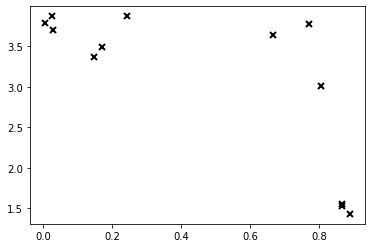

In [2]:
data = np.genfromtxt('data/regression_1D.csv', delimiter=',')
X = data[:, 0].reshape(-1, 1)
Y = data[:, 1].reshape(-1, 1)

plt.plot(X, Y, 'kx', mew=2);

We will consider the following probabilistic model:
$$ Y_i = f(X_i) + \varepsilon_i , $$
where $f \sim \mathcal{GP}(\mu(\cdot), k(\cdot, \cdot'))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

## Choose a kernel 
Several kernels (covariance functions) are implemented in GPflow. You can easily combine them to create new ones (see [Manipulating kernels](../advanced/kernels.ipynb)). You can also implement new covariance functions, as shown in the [Kernel design](../tailor/kernel_design.ipynb) notebook. Here, we will use a simple one:

In [3]:
k = gpflow.kernels.Matern52()

For more advanced kernels see the [advanced kernel notebook](../advanced/kernels.ipynb) (including kernels defined on subspaces). A summary of the kernel can be obtained by 

In [4]:
print_summary(k)

name                  class      transform    trainable    shape    dtype      value
--------------------  ---------  -----------  -----------  -------  -------  -------
Matern52.variance     Parameter  Softplus     True         ()       float64        1
Matern52.lengthscale  Parameter  Softplus     True         ()       float64        1


The Matern 5/2 kernel has two parameters: `lengthscale`, which encodes the "wiggliness" of the GP, and `variance`, which tunes the amplitude. They are both set to 1.0 as the default value. For more details on the meaning of the other columns, see [Manipulating kernels](../advanced/kernels.ipynb).

## Choose a mean function (optional)
It is common to choose $\mu = 0$, which is the GPflow default. 

However, if there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can  be beneficial. Some simple ones are provided in the `gpflow.mean_functions` module.

Here's how to define a linear mean function:

`meanf = gpflow.mean_functions.Linear()`

## Construct a model
A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll also set the variance of the likelihood to a sensible initial guess. 

In [5]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

A summary of the model can be obtained by

In [6]:
print_summary(m)

name                     class      transform    trainable    shape    dtype      value
-----------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64        1
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64        1
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64        1


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

You can access those values and manually set them to sensible initial guesses. For example:


In [7]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscale.assign(0.3)

## Optimize the model parameters

To obtain meaningful predictions, you need to tune the model parameters (that is, the parameters of the kernel, the likelihood, and the mean function if applicable) to the data at hand. 

There are several optimizers available in GPflow. Here we use the `Scipy` optimizer, which by default implements the L-BFGS-B algorithm. (You can select other algorithms by using the `method=` keyword argument to its `minimize` method; see [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for details of available options.)

In [8]:
opt = gpflow.optimizers.Scipy()

In order to minimize the negative log marginal likelihood, we create a closure to be passed to the optimizer. We also need to specify the variables to train with `m.trainable_variables`, and the number of iterations.

In [9]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                     class      transform    trainable    shape    dtype       value
-----------------------  ---------  -----------  -----------  -------  -------  --------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64  8.89789
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.244844
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64  0.021478


Notice how the value column has changed.

The local optimum found by Maximum Likelihood might not be the one you want (for example, it might be overfitting or oversmooth). This depends on the initial values of the hyperparameters, and is specific to each dataset. As an alternative to Maximum Likelihood, [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb) is also available.

## Make predictions

We can now use the model to make some predictions at the new points `Xnew`. You might be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Because we are dealing with Gaussian probabilistic models, the predictions typically produce a mean and variance as output. Alternatively, you can obtain samples of `f(Xnew)` or the log density of the new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and marginal variance of $f$ at the points `Xnew`. 

 - `m.predict_f` with argument `full_cov=True` returns the mean and the full covariance matrix of $f$ at the points `Xnew`.

 - `m.predict_f_samples` returns samples of the latent function.

 - `m.predict_y` returns the mean and variance of a new data point (that is, it includes the noise variance).

 - `m.predict_log_density` returns the log density of the observations `Ynew` at `Xnew`.
 
We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution.

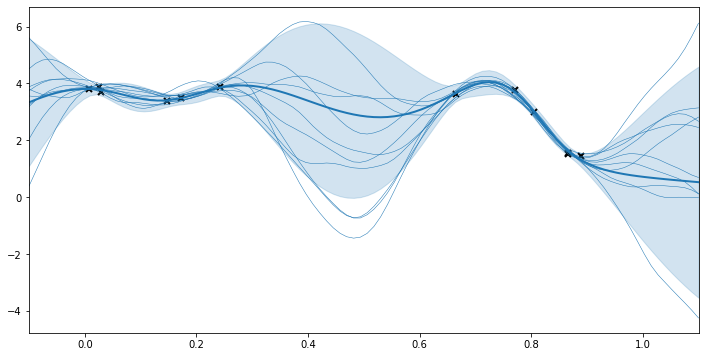

In [10]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);


## GP regression in higher dimensions

Very little changes when the input space has more than one dimension. By default, the `lengthscale` is an isotropic (scalar) parameter. It is generally recommended that you allow to tune a different lengthscale for each dimension (Automatic Relevance Determination, ARD): simply initialize `lengthscale` with an array of length $D$ corresponding to the input dimension of `X`.

## Further reading

  - [Stochastic Variational Inference for scalability with SVGP](../advanced/gps_for_big_data.ipynb) for cases where there are a large number of observations.
  - [Ordinal regression](../advanced/ordinal_regression.ipynb) if the data is ordinal.
  - [Multi-output models and coregionalisation](../advanced/coregionalisation.ipynb) if `Y` is multidimensional.